In [1]:
# %%
import ot
import numpy as np
import otmol as otm
import pandas as pd
from openbabel import pybel
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import os
# %matplotlib widget

In [2]:
def RMSD(V, W):
    """ 
    Calculate Root-mean-square deviation from two sets of vectors V and W.
    """
    N = V.shape[0]
    return np.sqrt(np.sum((V-W)**2)/N)

def compare_lists(list1, list2):
    """
    Compare two lists and return the indices and elements where they differ.

    Args:
        list1 (list): The first list to compare.
        list2 (list): The second list to compare.

    Returns:
        list: A list of tuples, where each tuple contains the index and the differing elements
              in the format (index, element_from_list1, element_from_list2).
    """
    differences = []
    # Compare elements up to the length of the shorter list
    for i in range(len(list1)):
        if list1[i] != list2[i]:
            differences.append((i, list1[i], list2[i]))

    return differences

def parse_molecule_pairs(file_path, mol_type: str = 'water cluster'):
    """
    Parses a file containing molecule pairs separated by an underscore ('_').

    Parameters:
    ----------
    file_path : str
        Path to the file containing molecule pairs.

    Returns:
    -------
    list of lists
        A list where each element is a pair [molA, molB].
    """
    molecule_pairs = []
    with open(file_path, 'r') as file:
        if mol_type == 'water cluster' or mol_type == 'S1':
            for line in file:
                line = line.strip()  # Remove any leading/trailing whitespace
                if line:  # Skip empty lines
                    # Some lines are like "molA_molB_2", and some are like "molA_molB"
                    molecule_pairs.append([line.split('_')[0], line.split('_')[1]])
        if mol_type == 'FGG':
            next(file)  # Skip the first line
            for line in file:
                line = line.strip()
                if line:
                    molA, molB = line.split('-')
                    molecule_pairs.append([molA, molB])
    return molecule_pairs

def cost_matrix(T_A: list = None, T_B: list = None, k = 1e11):
    n = len(T_A)
    m = len(T_B)
    C = np.zeros((n, m), dtype=float)
    for i in range(n):
        for j in range(m):
            if  T_A[i] == T_B[j]:
                C[i, j] = 0
            else:
                C[i, j] = k
    return C

def is_permutation_matrix(P):
    P = np.array(P)  # Convert to NumPy array if not already
    
    # 1. Check if square
    if P.shape[0] != P.shape[1]:
        return False
    
    # 2. Check all entries are 0 or 1
    if not np.all((P == 0) | (P == 1)):
        return False
    
    # 3. Check row sums = 1 (exactly one '1' per row)
    if not np.all(P.sum(axis=1) == 1):
        return False
    
    # 4. Check column sums = 1 (exactly one '1' per column)
    if not np.all(P.sum(axis=0) == 1):
        return False
    
    return True

def permutation_to_matrix(permutation):
    """
    Converts a permutation list to a permutation matrix.
    
    Args:
        permutation (list or array): A list or array representing the permutation.
                                     For example, [2, 0, 1] means index 0 maps to 2, index 1 maps to 0, etc.
    
    Returns:
        numpy.ndarray: A permutation matrix.
    """
    n = len(permutation)
    matrix = np.zeros((n, n), dtype=int)
    for i, j in enumerate(permutation):
        matrix[i, j] = 1
    return matrix

def parse_xyz(file_path):
    """
    Parse an XYZ file to extract atom name, SYBYL atom type, or atom connectivity and coordinates.

    Args:
        file_path (str): Path to the XYZ file.

    Returns:
        tuple: Two lists - one with desired atom category and another with coordinates.
    """
    atom_types = []
    coordinates = []

    with open(file_path, 'r') as file:
        lines = file.readlines()

        # Skip the first two lines (number of atoms and comment line)
        for line in lines[2:]:
            parts = line.strip().split()
            if len(parts) >= 4:
                atom_types.append(parts[0])  # First column is the SYBYL atom type
                coordinates.append([float(parts[1]), float(parts[2]), float(parts[3])])  # Next three columns are coordinates

    return np.array(coordinates, dtype=float), np.array(atom_types, dtype=str) 

In [11]:
def Experiment(mol_pair, data_path: str = None, method: str = 'fgw', 
               alpha_list: list = None, D_matrix: str = 'geodesic', p_list: list = None,
               setup: str = 'atom name'
               ):
    """
    Experiment with ArbAlign data.
    """
    results = []
    # Load the molecule pairs from the specified file
    for subfolder, nameA, nameB in mol_pair:
        if setup == 'atom name':
            molA = next(pybel.readfile('xyz', os.path.join(data_path, subfolder, nameA)))
            molB = next(pybel.readfile('xyz', os.path.join(data_path, subfolder, nameB)))
            # Basic processing of the molecules
            X_A, T_A, B_A = otm.tl.process_molecule(molA) # Output (1) spatial coordinates, (2) atom types, and (3) bonds as numpy arrays.
            X_B, T_B, B_B = otm.tl.process_molecule(molB)
        if setup == 'atom type':
            pass
        if setup == 'atom connectivity':
            pass
        C = cost_matrix(T_A, T_B, 1e12)
        D_A = distance_matrix(X_A, X_A)
        D_B = distance_matrix(X_B, X_B)
        rmsd_best = 1e10
        p_best = None
        P_best = None
        alpha_best = None
        if method == 'fgw':
        # Fused Gromov-Wasserstein
            for alpha in alpha_list:
                for p in p_list:
                    #if D_matrix == 'geodesic':
                    #    P = otm.tl.molecule_optimal_transport(C, D_A**p, D_B**p, method=method, alpha=alpha)
                    if D_matrix == 'euclidean':
                        P = otm.tl.molecule_optimal_transport(C, D_A**p, D_B**p, method=method, alpha=alpha)
                    assignment = np.argmax(P, axis=1)
                    if len(np.unique(assignment)) == X_A.shape[0]:
                        X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, permutation_to_matrix(assignment))
                        rmsd = RMSD(X_A, X_B_aligned[assignment])
                        if rmsd < rmsd_best:
                            rmsd_best = rmsd
                            p_best = p
                            P_best = P
                            alpha_best = alpha
            optimal_assignment = np.argmax(P_best, axis=1)
            
        if len(np.unique(optimal_assignment)) != X_A.shape[0]: # check if the assignment is 1 to 1
            print(nameA, nameB, 'Warning: the assignment is not 1 to 1')
        if compare_lists(T_A, T_B[optimal_assignment]): # check if atom names are matched
            print(nameA, nameB, 'Warning: unmatched {} exists'.format(setup))
        results.append({
            'nameA': nameA,
            'nameB': nameB,
            'RMSD(otmol+{})'.format(setup): rmsd_best,
            '# atoms': X_A.shape[0],
            'alpha': alpha_best,
            'p': p_best,
            'assignment': optimal_assignment,
            #'atomname_diff': compare_lists(T_A, T_B[optimal_assignment])
        }) 
        print(nameA, nameB, rmsd_best)

    return pd.DataFrame(results)

In [7]:
group1_data_path = "./Our_Benchmark_20250410_ver1/Cyclic_Peptide/Backbone_Most_Similar"
group1_info = pd.read_csv('./Our_Benchmark_20250410_ver1/Cyclic_Peptide/Backbone_Most_similar_dihedral_angle.csv')
#mol_pair_list_path = os.path.join(data_path, 'list')
#molecule_pairs = parse_molecule_pairs(mol_pair_list_path, mol_type='FGG')
group1_info

,RMSD,folder,reference,subfolder,target,mer
0,1.307,../Backbone_Most_Similar,ALPRAL10_2_fixed_backbone.xyz,c4mers,CEJSUF_fixed_backbone.xyz,4
1,0.070,../Backbone_Most_Similar,CGPGAP10_fixed_backbone.xyz,c5mers,PAPGAP_fixed_backbone.xyz,5
2,0.107,../Backbone_Most_Similar,BIHXUL10_fixed_backbone.xyz,c6mers,CINYED_fixed_backbone.xyz,6
3,0.322,../Backbone_Most_Similar,LACSUD_fixed_backbone.xyz,c7mers,TALVAD_fixed_backbone.xyz,7
4,2.303,../Backbone_Most_Similar,EVAPUM_fixed_backbone.xyz,c8mers,UZUKUW_fixed_backbone.xyz,8


In [6]:
for subf, namea, nameb in zip(group1_info['subfolder'], group1_info['reference'], group1_info['target']):
    print(subf, namea, nameb)

c4mers ALPRAL10_2_fixed_backbone.xyz CEJSUF_fixed_backbone.xyz
c5mers CGPGAP10_fixed_backbone.xyz PAPGAP_fixed_backbone.xyz
c6mers BIHXUL10_fixed_backbone.xyz CINYED_fixed_backbone.xyz
c7mers LACSUD_fixed_backbone.xyz TALVAD_fixed_backbone.xyz
c8mers EVAPUM_fixed_backbone.xyz UZUKUW_fixed_backbone.xyz


In [12]:
group1_res = Experiment(zip(group1_info['subfolder'], group1_info['reference'], group1_info['target']), group1_data_path, setup='atom name', method='fgw', D_matrix='euclidean', alpha_list=np.linspace(0,0.1,1000), p_list=[0.5,1,2])

ALPRAL10_2_fixed_backbone.xyz CEJSUF_fixed_backbone.xyz 0.11329876297674482
CGPGAP10_fixed_backbone.xyz PAPGAP_fixed_backbone.xyz 0.06982718888465207
BIHXUL10_fixed_backbone.xyz CINYED_fixed_backbone.xyz 0.10743477108483794
LACSUD_fixed_backbone.xyz TALVAD_fixed_backbone.xyz 0.3221520581700915
EVAPUM_fixed_backbone.xyz UZUKUW_fixed_backbone.xyz 0.2039941370971049


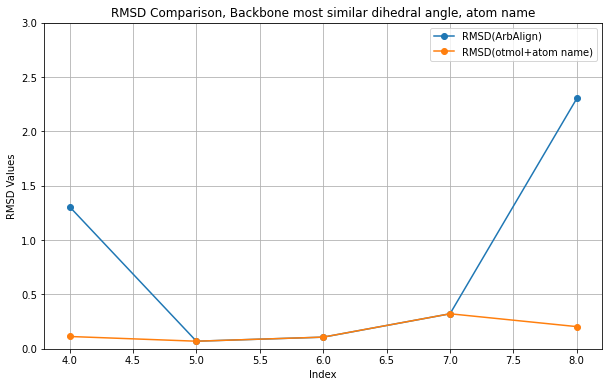

In [16]:
combined_df = pd.concat([group1_res, group1_info], axis=1).rename(columns={'RMSD': 'RMSD(ArbAlign)'})
# Plot the specified columns against the Index column
columns_to_plot = ["RMSD(ArbAlign)", "RMSD(otmol+atom name)"]
#"RMSD(KM-ByAtomType)", "RMSD(KM-byAtomConn)", 
plt.figure(figsize=(10,6))
# Plot each column against the Index column
for column in columns_to_plot:
    plt.plot(combined_df['mer'], combined_df[column], marker='o', label=column)
plt.title("RMSD Comparison, Backbone most similar dihedral angle, atom name")
plt.xlabel("Index")
plt.ylabel("RMSD Values")
plt.ylim(0, 3)
#plt.xticks(range(2,16))
plt.legend()
plt.grid(True)

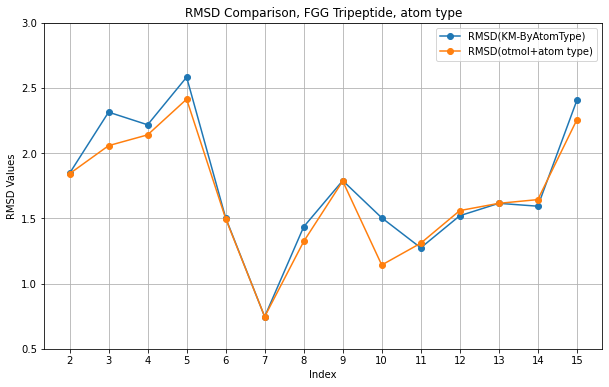

In [26]:
columns_to_plot = ["RMSD(KM-ByAtomType)", "RMSD(otmol+atom type)"]
#"RMSD(KM-ByAtomType)", "RMSD(KM-byAtomConn)", 
plt.figure(figsize=(10,6))
# Plot each column against the Index column
for column in columns_to_plot:
    plt.plot(range(2,16), combined_df[column], marker='o', label=column)
plt.title("RMSD Comparison, FGG Tripeptide, atom type")
plt.xlabel("Index")
plt.ylabel("RMSD Values")
plt.ylim(0.5, 3)
plt.xticks(range(2,16))
plt.legend()
plt.grid(True)

Backbone most different

In [18]:
group2_data_path = "./Our_Benchmark_20250410_ver1/Cyclic_Peptide/Backbone_Most_Different"
group2_info = pd.read_csv('./Our_Benchmark_20250410_ver1/Cyclic_Peptide/Backbone_Most_different_dihedral_angle.csv')
#mol_pair_list_path = os.path.join(data_path, 'list')
#molecule_pairs = parse_molecule_pairs(mol_pair_list_path, mol_type='FGG')
group2_info

,RMSD,folder,reference,subfolder,target,mer
0,1.599,../Backbone_Most_Different,CEJSUF_fixed_backbone.xyz,c4mers,RUQVAB_fixed_backbone.xyz,4
1,1.351,../Backbone_Most_Different,CGPSAQ_fixed_backbone.xyz,c5mers,FUDWIK_fixed_backbone.xyz,5
2,1.653,../Backbone_Most_Different,BUYXOI_fixed_backbone.xyz,c6mers,GGAAGG_fixed_backbone.xyz,6
3,1.597,../Backbone_Most_Different,JUXHAL_fixed_backbone.xyz,c7mers,ZORRED_fixed_backbone.xyz,7
4,2.091,../Backbone_Most_Different,NIWHEH_fixed_backbone.xyz,c8mers,cNPF_NMR_backbone.xyz,8


In [33]:
group2_res = Experiment(zip(group2_info['subfolder'], group2_info['reference'], group2_info['target']), group2_data_path, setup='atom name', method='fgw', D_matrix='euclidean', alpha_list=np.linspace(0,0.1,1000), p_list=[0.5,1,2])

CEJSUF_fixed_backbone.xyz RUQVAB_fixed_backbone.xyz 1.2529858098634894
CGPSAQ_fixed_backbone.xyz FUDWIK_fixed_backbone.xyz 0.855925445848091
BUYXOI_fixed_backbone.xyz GGAAGG_fixed_backbone.xyz 1.4511653184839268
JUXHAL_fixed_backbone.xyz ZORRED_fixed_backbone.xyz 1.5475172758049678
NIWHEH_fixed_backbone.xyz cNPF_NMR_backbone.xyz 1.1151885606834953


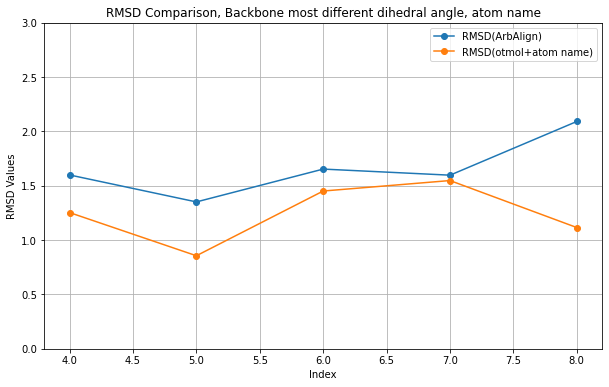

In [26]:
combined_df = pd.concat([group2_res, group2_info], axis=1).rename(columns={'RMSD': 'RMSD(ArbAlign)'})
# Plot the specified columns against the Index column
columns_to_plot = ["RMSD(ArbAlign)", "RMSD(otmol+atom name)"]
#"RMSD(KM-ByAtomType)", "RMSD(KM-byAtomConn)", 
plt.figure(figsize=(10,6))
# Plot each column against the Index column
for column in columns_to_plot:
    plt.plot(combined_df['mer'], combined_df[column], marker='o', label=column)
plt.title("RMSD Comparison, Backbone most different dihedral angle, atom name")
plt.xlabel("Index")
plt.ylabel("RMSD Values")
plt.ylim(0, 3)
#plt.xticks(range(2,16))
plt.legend()
plt.grid(True)

all backbone largest RMSD pair

In [29]:
group3_data_path = "./Our_Benchmark_20250410_ver1/Cyclic_Peptide/All_Backbone_XYZs"
group3_info = pd.read_csv('./Our_Benchmark_20250410_ver1/Cyclic_Peptide/All_Backbone_Largest_RMSD_Pair.csv')
#mol_pair_list_path = os.path.join(data_path, 'list')
#molecule_pairs = parse_molecule_pairs(mol_pair_list_path, mol_type='FGG')
group3_info

,RMSD,folder,reference,subfolder,target,mer
0,1.684,../All_Backbone_XYZs/,ALPRAL10_2_fixed_backbone.xyz,c4mers,RUQVAB_fixed_backbone.xyz,4
1,1.405,../All_Backbone_XYZs/,CGPSAQ_fixed_backbone.xyz,c5mers,DABVIL_fixed_backbone.xyz,5
2,2.183,../All_Backbone_XYZs/,BINJIR_fixed_backbone.xyz,c6mers,DUYTIA_fixed_backbone.xyz,6
3,2.403,../All_Backbone_XYZs/,TALVAD_fixed_backbone.xyz,c7mers,ZOHMIS_fixed_backbone.xyz,7
4,2.875,../All_Backbone_XYZs/,DASXIE_fixed_backbone.xyz,c8mers,EVAPUM_fixed_backbone.xyz,8


ALPRAL10_2_fixed_backbone.xyz RUQVAB_fixed_backbone.xyz 1.2725078002816559
CGPSAQ_fixed_backbone.xyz DABVIL_fixed_backbone.xyz 1.1045261079136965
BINJIR_fixed_backbone.xyz DUYTIA_fixed_backbone.xyz 1.4550977248345165
TALVAD_fixed_backbone.xyz ZOHMIS_fixed_backbone.xyz 1.1590461690372678
DASXIE_fixed_backbone.xyz EVAPUM_fixed_backbone.xyz 1.5925730497534119


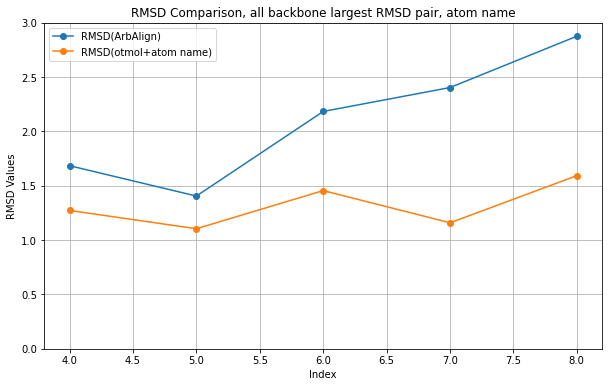

In [31]:
group3_res = Experiment(zip(group3_info['subfolder'], group3_info['reference'], group3_info['target']), group3_data_path, setup='atom name', method='fgw', D_matrix='euclidean', alpha_list=np.linspace(0,0.1,1000), p_list=[0.5,1,2])
combined_df = pd.concat([group3_res, group3_info], axis=1).rename(columns={'RMSD': 'RMSD(ArbAlign)'})
# Plot the specified columns against the Index column
columns_to_plot = ["RMSD(ArbAlign)", "RMSD(otmol+atom name)"]
#"RMSD(KM-ByAtomType)", "RMSD(KM-byAtomConn)", 
plt.figure(figsize=(10,6))
# Plot each column against the Index column
for column in columns_to_plot:
    plt.plot(combined_df['mer'], combined_df[column], marker='o', label=column)
plt.title("RMSD Comparison, all backbone largest RMSD pair, atom name")
plt.xlabel("Index")
plt.ylabel("RMSD Values")
plt.ylim(0, 3)
#plt.xticks(range(2,16))
plt.legend()
plt.grid(True)

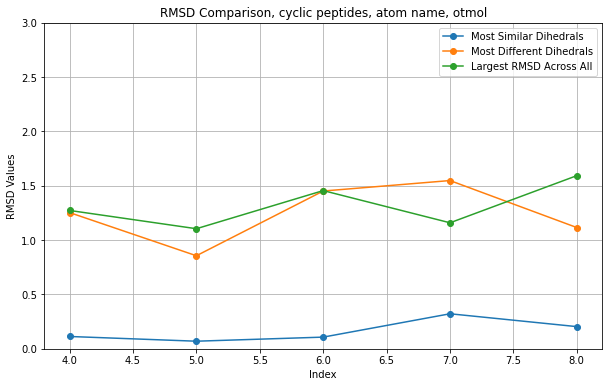

In [38]:
combined_df = pd.concat([group1_info['mer'], group1_res.rename(columns={'RMSD(otmol+atom name)': 'Most Similar Dihedrals'}), group2_res.rename(columns={'RMSD(otmol+atom name)': 'Most Different Dihedrals'}), group3_res.rename(columns={'RMSD(otmol+atom name)': 'Largest RMSD Across All'})], axis=1)
# Plot the specified columns against the Index column
columns_to_plot = ["Most Similar Dihedrals", "Most Different Dihedrals", "Largest RMSD Across All"]
plt.figure(figsize=(10,6))
# Plot each column against the Index column
for column in columns_to_plot:
    plt.plot(combined_df['mer'], combined_df[column], marker='o', label=column)
plt.title("RMSD Comparison, cyclic peptides, atom name, otmol")
plt.xlabel("Index")
plt.ylabel("RMSD Values")
plt.ylim(0, 3)
#plt.xticks(range(2,16))
plt.legend()
plt.grid(True)

In [36]:
combined_df = pd.concat([group1_info['mer'], group1_res.rename(columns={'RMSD(otmol+atom name)': 'Most similar'}), group2_res.rename({'RMSD(otmol+atom name)': 'Most different'}), group3_res.rename({'RMSD(otmol+atom name)': 'All backbone largest'})], axis=1)
combined_df

,mer,nameA,nameB,Most similar,# atoms,alpha,p,assignment,nameA,nameB,...,alpha,p,assignment,nameA,nameB,RMSD(otmol+atom name),# atoms,alpha,p,assignment
0,4,ALPRAL10_2_fixed_backbone.xyz,CEJSUF_fixed_backbone.xyz,0.113299,16,0.0002,2,"[12, 13, 14, 15, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9,...",CEJSUF_fixed_backbone.xyz,RUQVAB_fixed_backbone.xyz,...,0.000200,2,"[8, 9, 10, 11, 12, 13, 14, 15, 0, 1, 2, 3, 4, ...",ALPRAL10_2_fixed_backbone.xyz,RUQVAB_fixed_backbone.xyz,1.272508,16,0.000601,1,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0, ..."
1,5,CGPGAP10_fixed_backbone.xyz,PAPGAP_fixed_backbone.xyz,0.069827,20,0.0001,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",CGPSAQ_fixed_backbone.xyz,FUDWIK_fixed_backbone.xyz,...,0.000300,2,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...",CGPSAQ_fixed_backbone.xyz,DABVIL_fixed_backbone.xyz,1.104526,20,0.000300,2,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
2,6,BIHXUL10_fixed_backbone.xyz,CINYED_fixed_backbone.xyz,0.107435,24,0.0001,2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",BUYXOI_fixed_backbone.xyz,GGAAGG_fixed_backbone.xyz,...,0.003604,1,"[18, 16, 19, 17, 20, 23, 22, 21, 0, 3, 2, 1, 4...",BINJIR_fixed_backbone.xyz,DUYTIA_fixed_backbone.xyz,1.455098,24,0.000300,1,"[5, 4, 7, 6, 8, 11, 9, 10, 12, 15, 13, 14, 16,..."
3,7,LACSUD_fixed_backbone.xyz,TALVAD_fixed_backbone.xyz,0.322152,28,0.0001,2,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...",JUXHAL_fixed_backbone.xyz,ZORRED_fixed_backbone.xyz,...,0.004004,1,"[4, 2, 1, 3, 0, 26, 25, 27, 24, 22, 21, 23, 20...",TALVAD_fixed_backbone.xyz,ZOHMIS_fixed_backbone.xyz,1.159046,28,0.000400,1,"[20, 21, 22, 23, 24, 25, 26, 27, 0, 1, 2, 3, 4..."
4,8,EVAPUM_fixed_backbone.xyz,UZUKUW_fixed_backbone.xyz,0.203994,32,0.0001,2,"[23, 20, 22, 21, 27, 24, 26, 25, 31, 28, 30, 2...",NIWHEH_fixed_backbone.xyz,cNPF_NMR_backbone.xyz,...,0.000100,2,"[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 3...",DASXIE_fixed_backbone.xyz,EVAPUM_fixed_backbone.xyz,1.592573,32,0.015616,1,"[29, 31, 30, 28, 1, 3, 2, 0, 5, 7, 6, 4, 9, 11..."


# of potential non-zeros in P: 210
2.1552260859951216
[]


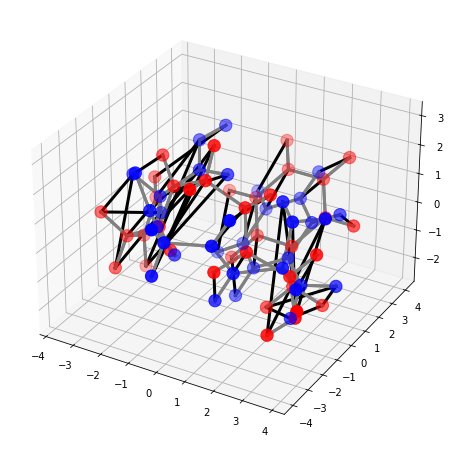

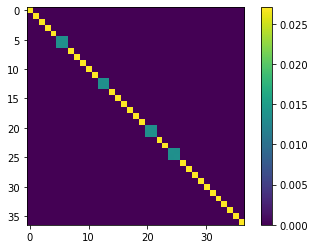

In [ ]:
# %%
# Fused supervised Gromov-Wasserstein
P = otm.tl.molecule_optimal_transport(C, D_A, D_B, method='fsgw', sgw_cutoff=5, alpha=0.5)
X_B_aligned = otm.tl.molecule_alignment_allow_reflection(X_A, X_B, P)
otm.pl.plot_alignment(X_A, X_B_aligned, B_A, B_B, P)
print(RMSD(X_A, X_B_aligned[np.argmax(P, axis=1)]))
print(compare_lists(T_A, T_B[np.argmax(P, axis=1)]))
plt.show()
plt.imshow(P)
plt.colorbar()